# 오토인코더
- 입력 데이터를 잠재벡터 공간에 표시한다
- 새로운 특성 표현 방법으로 차원을 줄일 수 있고, 압축된 표현법을 사용하여 다양한 제어가 가능해진다
- [오토인코더 개념](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798)
- Stacked Autoencoder
 - 잠재 벡터인, 히든 계층을 여러 층으로 쌓는 모델
- Denoising AE
 - 입력으로 x + noise 를 사용하고 출력으로 x를 사용하여 더 강건한 인코딩 모델을 만든다


# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.9.0  Device: cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

# 데이터
- FashionMNIST 데이터 사용

In [4]:
train_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                     train = False,
                                     transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


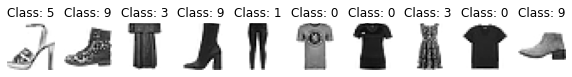

In [6]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

# MLP 모델 구성

## 모델 정의

In [7]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        # 인코더와 디코더 두개로 구성된다
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32),)
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),)

    # 순방향 전파를 구현    
    def forward(self, x):
        encoded = self.encoder(x)  # 이부분이 잠재 벡터가 된다
        decoded = self.decoder(encoded)
        return encoded, decoded

In [8]:
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()  # 원본과 얼마나 똑같이 재구현 했는지를 MSE로 평가

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


## 학습

In [9]:
def train(model, train_loader, optimizer, log_interval):
    model.train()  # 학습 상태로 설정
    for batch_idx, (image, _) in enumerate(train_loader):  # 레이블은 사용하지 않는다
        image = image.view(-1, 28 * 28).to(DEVICE)
        target = image.view(-1, 28 * 28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

## 성능 평가

In [10]:
# 평가 함수 정의
def evaluate(model, test_loader):
    model.eval()           # 모델을 평가 상태로 지정
    test_loss = 0
    real_image = []
    gen_image = []
    with torch.no_grad():  # 평가시에는 그라디언트 전파를 정지한다
        for image, _ in test_loader:
            image = image.view(-1, 28 * 28).to(DEVICE)
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image)
            
            test_loss += criterion(decoded, image).item()
            real_image.append(image.to("cpu"))
            gen_image.append(decoded.to("cpu"))
            
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)

    return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 0.213169
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.025629
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.027338
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.016729
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.018759
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.016935
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.017930
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.016835
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.013649
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.014471

[EPOCH: 1], 	Test Loss: 0.0153


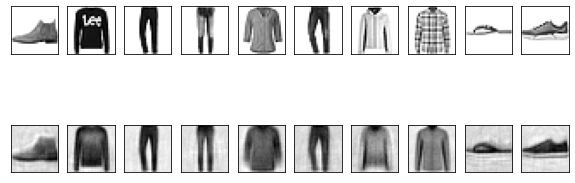

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.014899
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.015647
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.012560
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.012450
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.011496
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.013176
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.018575
Train Epoch: 2 [44800/60000 (75%)]	Train Loss: 0.012592
Train Epoch: 2 [51200/60000 (85%)]	Train Loss: 0.012090
Train Epoch: 2 [57600/60000 (96%)]	Train Loss: 0.010524

[EPOCH: 2], 	Test Loss: 0.0134


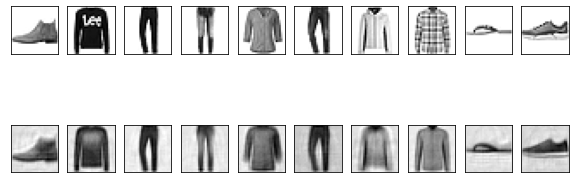

Train Epoch: 3 [0/60000 (0%)]	Train Loss: 0.014632
Train Epoch: 3 [6400/60000 (11%)]	Train Loss: 0.014845
Train Epoch: 3 [12800/60000 (21%)]	Train Loss: 0.014055
Train Epoch: 3 [19200/60000 (32%)]	Train Loss: 0.012572
Train Epoch: 3 [25600/60000 (43%)]	Train Loss: 0.011800
Train Epoch: 3 [32000/60000 (53%)]	Train Loss: 0.009333
Train Epoch: 3 [38400/60000 (64%)]	Train Loss: 0.015345
Train Epoch: 3 [44800/60000 (75%)]	Train Loss: 0.010707
Train Epoch: 3 [51200/60000 (85%)]	Train Loss: 0.011924
Train Epoch: 3 [57600/60000 (96%)]	Train Loss: 0.013319

[EPOCH: 3], 	Test Loss: 0.0120


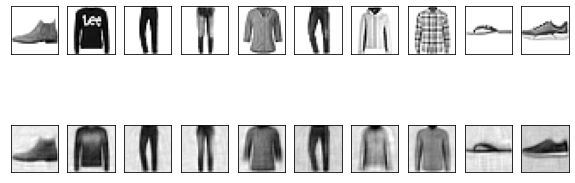

Train Epoch: 4 [0/60000 (0%)]	Train Loss: 0.013206
Train Epoch: 4 [6400/60000 (11%)]	Train Loss: 0.010416
Train Epoch: 4 [12800/60000 (21%)]	Train Loss: 0.013133
Train Epoch: 4 [19200/60000 (32%)]	Train Loss: 0.012877
Train Epoch: 4 [25600/60000 (43%)]	Train Loss: 0.011896
Train Epoch: 4 [32000/60000 (53%)]	Train Loss: 0.013176
Train Epoch: 4 [38400/60000 (64%)]	Train Loss: 0.012435
Train Epoch: 4 [44800/60000 (75%)]	Train Loss: 0.011333
Train Epoch: 4 [51200/60000 (85%)]	Train Loss: 0.011873
Train Epoch: 4 [57600/60000 (96%)]	Train Loss: 0.013063

[EPOCH: 4], 	Test Loss: 0.0114


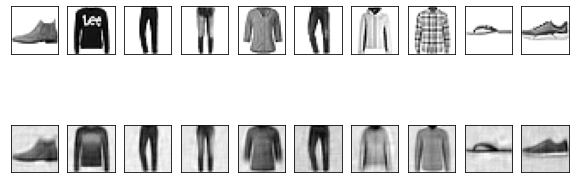

Train Epoch: 5 [0/60000 (0%)]	Train Loss: 0.010305
Train Epoch: 5 [6400/60000 (11%)]	Train Loss: 0.011782
Train Epoch: 5 [12800/60000 (21%)]	Train Loss: 0.009411
Train Epoch: 5 [19200/60000 (32%)]	Train Loss: 0.011426
Train Epoch: 5 [25600/60000 (43%)]	Train Loss: 0.011675
Train Epoch: 5 [32000/60000 (53%)]	Train Loss: 0.009911
Train Epoch: 5 [38400/60000 (64%)]	Train Loss: 0.009590
Train Epoch: 5 [44800/60000 (75%)]	Train Loss: 0.012549
Train Epoch: 5 [51200/60000 (85%)]	Train Loss: 0.008021
Train Epoch: 5 [57600/60000 (96%)]	Train Loss: 0.010923

[EPOCH: 5], 	Test Loss: 0.0109


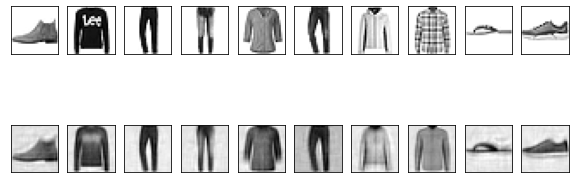

Train Epoch: 6 [0/60000 (0%)]	Train Loss: 0.012493
Train Epoch: 6 [6400/60000 (11%)]	Train Loss: 0.010082
Train Epoch: 6 [12800/60000 (21%)]	Train Loss: 0.012083
Train Epoch: 6 [19200/60000 (32%)]	Train Loss: 0.015342
Train Epoch: 6 [25600/60000 (43%)]	Train Loss: 0.010175
Train Epoch: 6 [32000/60000 (53%)]	Train Loss: 0.011698
Train Epoch: 6 [38400/60000 (64%)]	Train Loss: 0.009982
Train Epoch: 6 [44800/60000 (75%)]	Train Loss: 0.012566
Train Epoch: 6 [51200/60000 (85%)]	Train Loss: 0.009560
Train Epoch: 6 [57600/60000 (96%)]	Train Loss: 0.008194

[EPOCH: 6], 	Test Loss: 0.0105


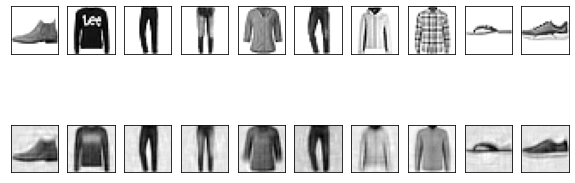

Train Epoch: 7 [0/60000 (0%)]	Train Loss: 0.008702
Train Epoch: 7 [6400/60000 (11%)]	Train Loss: 0.009114
Train Epoch: 7 [12800/60000 (21%)]	Train Loss: 0.011695
Train Epoch: 7 [19200/60000 (32%)]	Train Loss: 0.009591
Train Epoch: 7 [25600/60000 (43%)]	Train Loss: 0.010635
Train Epoch: 7 [32000/60000 (53%)]	Train Loss: 0.008528
Train Epoch: 7 [38400/60000 (64%)]	Train Loss: 0.009243
Train Epoch: 7 [44800/60000 (75%)]	Train Loss: 0.008806
Train Epoch: 7 [51200/60000 (85%)]	Train Loss: 0.012659
Train Epoch: 7 [57600/60000 (96%)]	Train Loss: 0.009302

[EPOCH: 7], 	Test Loss: 0.0103


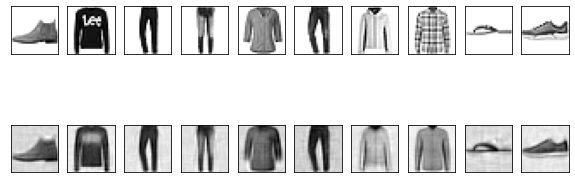

Train Epoch: 8 [0/60000 (0%)]	Train Loss: 0.008962
Train Epoch: 8 [6400/60000 (11%)]	Train Loss: 0.009551
Train Epoch: 8 [12800/60000 (21%)]	Train Loss: 0.014276
Train Epoch: 8 [19200/60000 (32%)]	Train Loss: 0.009547
Train Epoch: 8 [25600/60000 (43%)]	Train Loss: 0.009468
Train Epoch: 8 [32000/60000 (53%)]	Train Loss: 0.010739
Train Epoch: 8 [38400/60000 (64%)]	Train Loss: 0.009026
Train Epoch: 8 [44800/60000 (75%)]	Train Loss: 0.009121
Train Epoch: 8 [51200/60000 (85%)]	Train Loss: 0.011663
Train Epoch: 8 [57600/60000 (96%)]	Train Loss: 0.009873

[EPOCH: 8], 	Test Loss: 0.0101


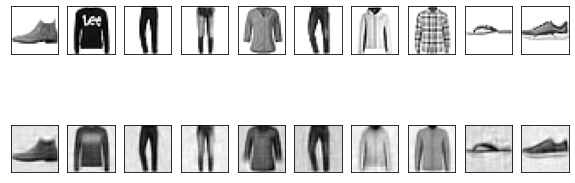

Train Epoch: 9 [0/60000 (0%)]	Train Loss: 0.010791
Train Epoch: 9 [6400/60000 (11%)]	Train Loss: 0.008781
Train Epoch: 9 [12800/60000 (21%)]	Train Loss: 0.010126
Train Epoch: 9 [19200/60000 (32%)]	Train Loss: 0.009522
Train Epoch: 9 [25600/60000 (43%)]	Train Loss: 0.007793
Train Epoch: 9 [32000/60000 (53%)]	Train Loss: 0.009554
Train Epoch: 9 [38400/60000 (64%)]	Train Loss: 0.009018
Train Epoch: 9 [44800/60000 (75%)]	Train Loss: 0.009665
Train Epoch: 9 [51200/60000 (85%)]	Train Loss: 0.012362
Train Epoch: 9 [57600/60000 (96%)]	Train Loss: 0.007599

[EPOCH: 9], 	Test Loss: 0.0100


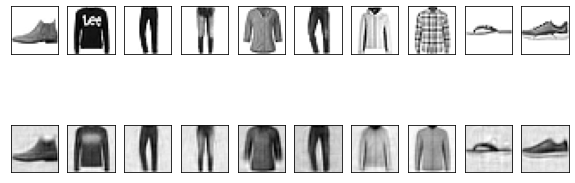

Train Epoch: 10 [0/60000 (0%)]	Train Loss: 0.011519
Train Epoch: 10 [6400/60000 (11%)]	Train Loss: 0.009642
Train Epoch: 10 [12800/60000 (21%)]	Train Loss: 0.009452
Train Epoch: 10 [19200/60000 (32%)]	Train Loss: 0.008777
Train Epoch: 10 [25600/60000 (43%)]	Train Loss: 0.010489
Train Epoch: 10 [32000/60000 (53%)]	Train Loss: 0.011145
Train Epoch: 10 [38400/60000 (64%)]	Train Loss: 0.011663
Train Epoch: 10 [44800/60000 (75%)]	Train Loss: 0.009366
Train Epoch: 10 [51200/60000 (85%)]	Train Loss: 0.007720
Train Epoch: 10 [57600/60000 (96%)]	Train Loss: 0.008937

[EPOCH: 10], 	Test Loss: 0.0099


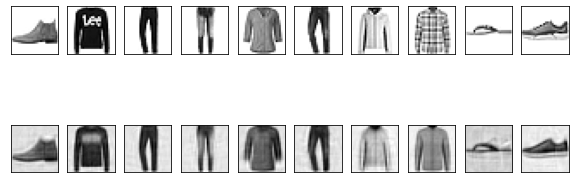

In [11]:
# 평가 실행
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()

# 연습
- 잠재 벡터의 크기를 바꾸어 본다